<a href="https://colab.research.google.com/github/FelipeAce96/Dates-Translation-Transformer/blob/master/DEMO_DATES_TRANSLATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOWNLOAD THE MODEL & DEPENDENCIES

In [1]:
!git clone https://github.com/FelipeAce96/Dates-Translation-Transformer.git

Cloning into 'Dates-Translation-Transformer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 25 (delta 5), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (25/25), 61.06 MiB | 8.29 MiB/s, done.


In [2]:
# Load tokenizers
import pickle

# loading tokenizers
with open('/content/Dates-Translation-Transformer/model_dates_checkpoint/source_tokenizer.pickle', 'rb') as handle:
    source_tokenizer = pickle.load(handle)
    
with open('/content/Dates-Translation-Transformer/model_dates_checkpoint/target_tokenizer.pickle', 'rb') as handle:
    target_tokenizer = pickle.load(handle)
    
source_tokenizer,target_tokenizer

(<keras.preprocessing.text.Tokenizer at 0x7f8d270afa90>,
 <keras.preprocessing.text.Tokenizer at 0x7f8d270aead0>)

In [3]:
# load the model

import tensorflow as tf

loaded = tf.saved_model.load('/content/Dates-Translation-Transformer/model_dates_checkpoint')
loaded_transformer = loaded.signatures['serving_default']

In [4]:
class Translator(tf.Module):
  def __init__(self,
               source_tokenizer, #input tokenizer
               target_tokenizer, #target tokenizer
               loaded_transformer, #model
               TX_SOURCE, TX_TARGET):
    
    self.source_tokenizer = source_tokenizer
    self.target_tokenizer = target_tokenizer
    self.loaded_transformer = loaded_transformer
    self.TX_SOURCE = TX_SOURCE
    self.TX_TARGET = TX_TARGET
    self.target_map = {v:k for k, v in target_tokenizer.word_index.items()}

  def __call__(self, sentence):

    tokenized_source = self.source_tokenizer.texts_to_sequences([sentence])
    tokenized_padded_source = tf.keras.preprocessing.sequence.pad_sequences(tokenized_source, maxlen=self.TX_SOURCE, padding='post', truncating='post')

    # As the output language is English, initialize the output with the `[START]` token.
    tokenized_target = self.target_tokenizer.texts_to_sequences(['#'])
    tokenized_target = tf.keras.preprocessing.sequence.pad_sequences(tokenized_target, maxlen=self.TX_TARGET, padding='post', truncating='post')

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.

    # Run from TX TARGET steps

    for t in range(self.TX_TARGET - 1):
      out = self.loaded_transformer(input_1 = tokenized_padded_source , input_2 = tokenized_target)
      predictions = out.get('output_1')
      attention_weights = out.get('output_2')
      # predictions = self.transformer([tokenized_padded_source, tokenized_target], training=False)
      predictions = predictions[:, t, :]  # Shape `(batch_size, 1, vocab_size)`.
      res = tf.argmax(predictions, axis=-1)
      tokenized_target[:, t +1 ] = res.numpy()[0]

    output_decoded = "".join([self.target_map.get(e) for e in tokenized_target[0]])
    print(f'Original Sentence: {sentence}')
    print('Translated Sentence:',output_decoded)

    #Tokens
    in_tokens = sentence.split()
    in_tokens = in_tokens[:self.TX_SOURCE]
    out_tokens = [x for x in output_decoded]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.

    # print('calculation attention weigths')
    # self.transformer([tokenized_padded_source, tokenized_target], training=False)
    # attention_weights = self.transformer.decoder.last_attn_scores

    return output_decoded, in_tokens, out_tokens, attention_weights

In [8]:
import matplotlib.pyplot as plt
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]
  ax = plt.gca()
  ax.matshow(attention[:,:len(in_tokens)])
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  ax.set_xticklabels(in_tokens, rotation=90)
  ax.set_yticklabels(translated_tokens)

In [5]:
#Define the translator
translator = Translator(
    source_tokenizer = source_tokenizer,
    target_tokenizer=target_tokenizer,
    loaded_transformer = loaded_transformer,
    TX_SOURCE=42, TX_TARGET=12)

In [6]:
translated, in_tokens, out_tokens, attention_weights = translator(
"""
Kurt Donald Cobain (feb 20, 1967) was an American musician who was the founder, lead vocalist, guitarist and primary songwriter of the rock band Nirvana. 
"""
)

Original Sentence: 
Kurt Donald Cobain (feb 20, 1967) was an American musician who was the founder, lead vocalist, guitarist and primary songwriter of the rock band Nirvana. 

Translated Sentence: #1967-02-20%


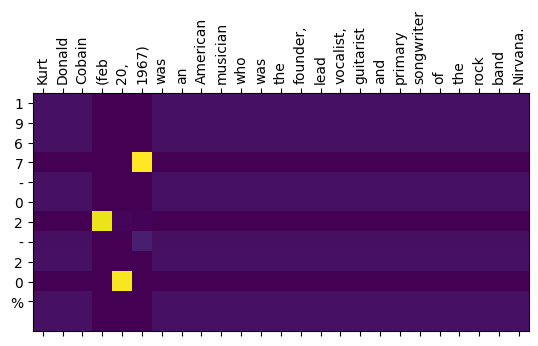

In [11]:
head=1
attention = attention_weights[0][head]
plot_attention_head(in_tokens, out_tokens, attention )

# USE THE MODEL

Original Sentence: born John Winston Lennon; thursday 9 of oct 1954) was an English singer, songwriter, musician and peace activist who achieved worldwide fame as founder, co-songwriter, co-lead vocalist and rhythm guitarist of the Beatles.
Translated Sentence: #1954-10-09%


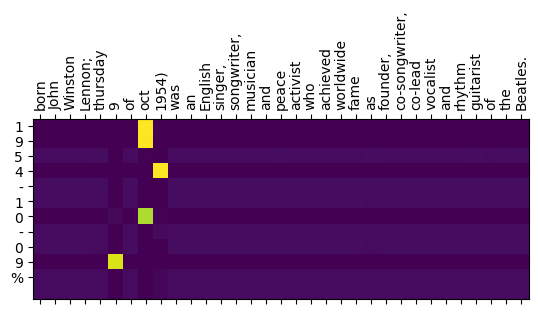

In [12]:
sentence = "born John Winston Lennon; thursday 9 of oct 1954) was an English singer, songwriter, musician and peace activist who achieved worldwide fame as founder, co-songwriter, co-lead vocalist and rhythm guitarist of the Beatles." #@param {type:"string"}
translated, in_tokens, out_tokens, attention_weights = translator(sentence)
head=0
attention = attention_weights[0][head]
plot_attention_head(in_tokens, out_tokens, attention )